![](https://cocalc.com/blobs/paste-0.05592430265117643?uuid=f0881709-ebf0-4ee4-ab45-cc6dc07f668f)

**Rayleigh-Bénard convection with a stochastic boundary condition**

This notebook applies the forward Kolmogorov equation and domain partitioning using mixture models to Rayleigh-Bénard convection with a stochastic boundary condition prescribed by an Ornstein–Uhlenbeck process. The Boussinesq equations are solved using the pseudo-spectral solver Dedalus ([Burns et al., 2020](https://doi.org/10.1103/PhysRevResearch.2.023068)), while the relevant terms in the forward Kolmogorov equation are estimated using histograms.

First let's import everything we need to run the rest of the notebook.

In [1]:
import numpy as np
import h5py
import json

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc('text', usetex=True)
matplotlib.rc('text.latex', preamble=r'\usepackage{amsfonts}')

**Problem Equations**

The Boussinesq equations are given by
\begin{equation}
    \begin{split}
    \frac{d \boldsymbol{U}_{t}}{dt}&=B_{t}\boldsymbol{e}_{3}-\nabla P_{t} -\boldsymbol{U}_{t}\cdot\nabla \boldsymbol{U}_{t}+\alpha_{1}\Delta \boldsymbol{U}_{t},\\
    \frac{d B_{t}}{dt}&=-\boldsymbol{U}_{t}\cdot\nabla {B}_{t} -\alpha_{2}\Delta B_{t}, \\
    \nabla\cdot\boldsymbol{U}_{t}&=0,
    \end{split}
\end{equation}
and are solved in a domain which is spatially periodic in $X^1 \in [0,4)$ and of unit height in the vertical $X^3 \in [0,1]$ with spatially-uniform buoyancy
\begin{equation}
    B_t = -1/2, \quad \text{at} \quad X^3 = 1,\\
\end{equation}
imposed on the top boundary, while on the bottom boundary the imposed buoyancy is spatially uniform of mean $\mu=1/2$ and follows an Ornstein-Uhlenbeck process in time such that
\begin{equation}
 dB_t = a (\mu - B_t) dt + \sigma dW_t, \quad \text{at} \quad X^3 = 0,\\
\end{equation}
where $a = 1/2,\sigma = 1$ are drift and diffusion coefficients respectively and $W_t$ a Wiener process. In terms of these scales, the Rayleigh number which we set to $10^7$ corresponds to a (non-dimensionalised) viscosity and diffusivity of $\alpha_1 = \alpha_2 = \sqrt{10^7}$, for a Prandtl number of unity.

**DNS data/simulation**

Starting from a random initial condition we then use the solver for the Boussinesq equations contained in $\texttt{main.py}$ to generate a time-series of:

- snapshots of the buoyancy $B_t$, velocity $\boldsymbol{U}_t$, buoyancy gradient $\nabla B_t$ and the velocity gradient $\nabla \boldsymbol{U}_t$ as fields
- point evaluations of the buoyancy $B_t$ and buoyancy gradient $\nabla B_t$ evaluated at the upper and lower boundaries

sampled every $t_s = 2$ and $t_s = 1/5$ time-units respectively. 

Due to the demands of the simulation results presented in the paper exceeding those of Cocalc we load the data rather than running this script directly in the notebook. However this data with adequate computational resources can be generated using $\texttt{main.py}$ and then treated using the routines provided in this notebook by changing the folders below. 

In [2]:
# Loading the data
fname_timeseries = './paper_data/timeseries/timeseries_s1.h5'
fname_fields = './paper_data/fields/fields_s1.h5'
params_fname = './paper_data/parameters.json'

Having loaded/generated the data we check the volume-averaged buoyancy flux $\mathbb{E}[W_t B_t]$ to check that a statistically stationary regime has been reached.

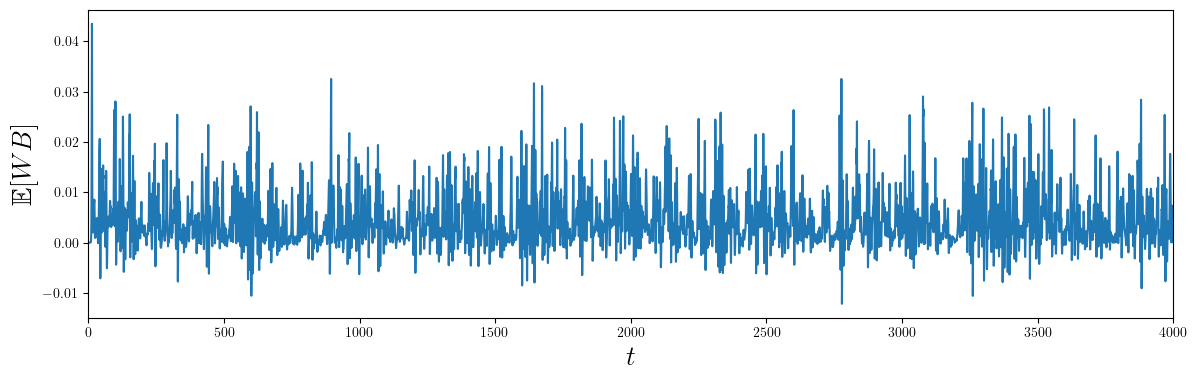

In [3]:
with open(params_fname) as f:
    params = json.load(f)

with h5py.File(fname_timeseries, mode='r') as file:
    t = file['tasks']['<wb>'].dims[0]['sim_time'][:]
    WB = file['tasks']['<wb>'][:].squeeze()

# Check volume-averaged buoyancy flux
plt.figure(figsize=(14, 4))
plt.plot(t,WB)
plt.xlabel(r'$t$',fontsize=20)
plt.ylabel(r'$\mathbb{E}[WB]$',fontsize=20)
plt.xlim([0,4000])
plt.show()  

**Partitions and mixture distributions**

Using the data snapshots generated by the Boussinesq equations we define: 

\begin{equation}
  f_{X}(x)=\sum_{z\in\mathbb{Z}}f_{X|Z}(x|z)\mathbb{P}\{Z=z\},
\end{equation}

where $\mathbb{P}\{Z=z\}$ is the proportion of the original control volume attributed to zone $z$. Here we partition the vertical domain into three zones $Z\in\{z_{0},z_{1},z_{2}\}$ defined by $f_{X|Z}$. In the boundary-layer zone above the bottom boundary $f_{X|Z}$ is proportional to the horizontally-and time-averaged diffusive heat flux $-\alpha_{2}\partial_{X^{3}}B_t$ and is given by

\begin{equation}
f_{X|Z}(x|z_{0}) = 
\begin{cases} 
\frac{1}{N} \frac{1}{T - t_0} \int_{t_0}^T \left( \frac{1}{L_x} \int_0^{L_x} - \alpha_2 \partial_{X^{3}}B_t \, dX^1 \right) \, dt,& \quad \text{for} \quad X^3 < 1/2, \\
0,& \quad \text{for} \quad X^3 > 1/2,
\end{cases}
\end{equation}

The central zone $f_{X|Z}(x|z_{1})$ is proportional to the horizontally-and time-averaged vertical buoyancy flux $W_tB_t$ and is given by

\begin{equation}
f_{X|Z}(x|z_{1}) = \frac{1}{N} \frac{1}{T - t_0} \int_{t_0}^T \left( \frac{1}{L_x} \int_0^{L_x} W_t B_t \, dX^1 \right) \, dt,
\end{equation}

In the boundary-layer zone below the top boundary $f_{X|Z}$ is again proportional to the horizontally-and time-averaged diffusive heat flux $-\alpha_{2}\partial_{X^{3}}B_t$ and is given by

\begin{equation}
f_{X|Z}(x|z_{2}) = 
\begin{cases} 
0,& \quad \text{for} \quad X^3 < 1/2, \\
\frac{1}{N} \frac{1}{T - t_0} \int_{t_0}^T \left( \frac{1}{L_x} \int_0^{L_x} - \alpha_2 \partial_{X^{3}}B_t \, dX^1 \right) \, dt,& \quad \text{for} \quad X^3 > 1/2, \\
\end{cases}
\end{equation}


The normalisation constant $N$ is determined such that

\begin{equation}
  \int f_{X}(x) \, dx = \int \sum_{z\in\mathbb{Z}}f_{X|Z}(x|z)\mathbb{P}\{Z=z\} \, dx = 1,
\end{equation}

When constructing these distributions we choose a $t_0 > 0$ in order to discard transients retained from the initial conditions.

In [4]:
from helper import time_average

# Define transient period to discard
t0 = 100

# Create empty set of sample distributions for internal and boundary points
f_Xs = [None]*3

# (a) Get 1d profiles to define f_X 
with h5py.File(fname_timeseries, mode='r') as file:
    t = file['tasks']['<wb>(z)'].dims[0]['sim_time'][:]
    z_1d = file['tasks']['<wb>(z)'].dims[2][0][:]
    
    # Unnormalised sample distributions based on buoyancy flux

    # Bottom zone
    f_Xs[0] = -params['alpha_2']*time_average( file['tasks']['<db_dz>(z)'][:], t, t0) 

    # Central zone
    f_Xs[1] =  time_average( file['tasks']['<wb>(z)'][:], t, t0)

    # top zone
    f_Xs[2] = -params['alpha_2']*time_average( file['tasks']['<db_dz>(z)'][:], t, t0)  

# (b) Split the diffusive buoyancy flux between the bottom and top boundary layer
f_Xs[0][ z_1d>params['Lz']/2 ] = 0 # Bottom half of the domain
f_Xs[2][ z_1d<params['Lz']/2 ] = 0 # Top half of the domain

# (c) Defined normalisation constant and normalise the sample distributions
N = np.trapezoid(f_Xs[0]+f_Xs[1]+f_Xs[2], x=z_1d)

f_Xs[0] = f_Xs[0]/N
f_Xs[1] = f_Xs[1]/N
f_Xs[2] = f_Xs[2]/N

Having determined the normalised distributions we then plot out the buoyancy field $B(X^1,X^3,t=t_0)$ with contours of the vertical velocity $W(X^1,X^3,t=t_0)$ superimposed alongside $f_X$ and the components of $f_{X|Z}$.

*Note: This takes about 1-2 minutes to run, as a large amount of data must be processed.*

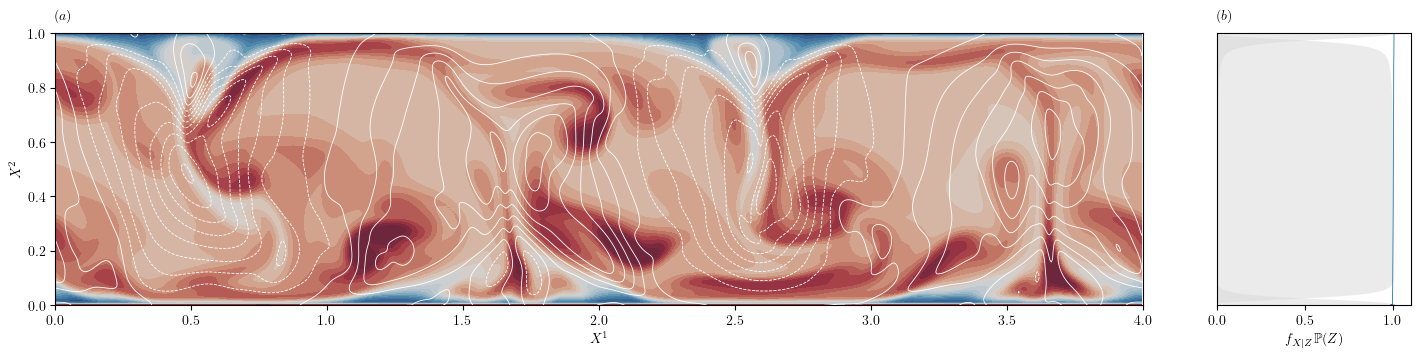

: 

In [ ]:
# Get boundary information from the wall slices  
with h5py.File(fname_fields, mode='r') as file:
    t = file['tasks']['b(z=0)'].dims[0]['sim_time'][:]
    Z = file['tasks']['b'].dims[2][0][:] # Chebyshev
    X = file['tasks']['b'].dims[1][0][:]
    B = file['tasks']['b'][:]
    U = file['tasks']['u'][:]
    grad_B = file['tasks']['grad_b'][:]
    grad_U = file['tasks']['grad_u'][:]

# Pick an index for the snapshot (after negative fluctuation in buoyancy at the bottom boundary)
idx = np.where(t>t0)[0][2]
fig, ax = plt.subplots(1,2,gridspec_kw={'width_ratios':[6,1],'wspace':0.05,'bottom':0.2},figsize=(2*9,2*2))

# Plot field
ax[0].contourf(X, Z, B[idx,:,:].T, np.linspace(-0.5, 0.5, 21), cmap='RdBu_r', extend='both')
ax[0].set_aspect('equal', adjustable='box')
ax[0].contourf(X, Z, 0*B[idx,:,:].T, [0,1e5], cmap='gray', alpha=0.3)
ax[0].contour(X, Z, U[idx,1,:,:].T,np.linspace(-1,1,21), colors='w',linewidths=0.6)
ax[0].set_xlabel(r'$X^{1}$')
ax[0].set_ylabel(r'$X^{2}$')
ax[0].set_xlim([0,params['Lx']])
ax[0].set_ylim([0,params['Lz']])
ax[0].annotate(r'$(a)$', xy=(0.0, 1.05), xycoords='axes fraction')

# Plot boundary layer and bulk zones
 
col = (0.85,0.85,0.85) # Define grey color

ax[1].fill_betweenx(z_1d, f_Xs[0], color=col, alpha=0.5, edgecolor=None)
ax[1].fill_betweenx(z_1d, f_Xs[1], color=col, alpha=0.5, edgecolor=None)
ax[1].fill_betweenx(z_1d, f_Xs[2], color=col, alpha=0.5, edgecolor=None)
ax[1].plot((f_Xs[0]+f_Xs[1]+f_Xs[2]), z_1d, '-C0', lw=0.6)
ax[1].set_xlabel(r'$f_{X|Z}\mathbb{P}(Z)$')
ax[1].set_yticks([])
ax[1].set_ylim([0,1])
ax[1].set_xlim([0,1.1])
ax[1].annotate(r'$(b)$', xy=(0.0, 1.05), xycoords='axes fraction')

plt.savefig('fig_field.pdf',dpi=100)
plt.show()

**Forward Kolmogorov equation for the zonal distribution $f_{\boldsymbol{Y}|Z}$**

Having determined $f_X$ and $f_{X|Z}$ we now illustrate how the partition yields useful information, to do so we focus on the contributions to the equations governing $f_{\boldsymbol{Y}|Z}$ from $V$ and $\mathbf{D}_1$ due to transport between the zones. The forward Kolmogorov equation for $f_{\boldsymbol{Y}}$ where $\boldsymbol{Y}_t = (W_t, B_t)$ is given by

\begin{equation}
\frac{\partial }{ \partial t} f_{\boldsymbol{Y}} =  - V f_{\boldsymbol{Y}} -\frac{\partial}{ \partial y_i} \left( \mathbf{D}^i_1 f_{\boldsymbol{Y}} \right) + \frac{\partial^2 }{ \partial y_i \partial y_j} \left( \mathbf{D}^{ij}_2 f_{\boldsymbol{Y}} \right),
\end{equation}
where
\begin{equation}
V = -\mathbb{E}[ W_t \partial_X \log f_X | \boldsymbol{Y}_t = \boldsymbol{y} ],
\end{equation}
and
\begin{equation}
    \mathbf{D}_{1}=
    \begin{pmatrix}
    0\\
    b
    \end{pmatrix}
    -\mathbb{E}_{\boldsymbol{Y}_{t}}
    \begin{bmatrix}
        -\alpha_{1}\nabla B_{t}\cdot\nabla \log f_{\boldsymbol{X}} & \\
        \partial_{Z} P_{t} - \alpha_{2}\nabla W_{t}\cdot\nabla \log f_{\boldsymbol{X}}   
    \end{bmatrix} + ??
\end{equation}

Substituting for 

\begin{equation}
  f_{X}(x)=\sum_{z\in\mathbb{Z}}f_{X|Z}(x|z)\mathbb{P}\{Z=z\}, \quad\quad f_{\boldsymbol{Y}}(\boldsymbol{y})=\sum_{z\in\mathbb{Z}}f_{\boldsymbol{Y}|Z}(x|z)\mathbb{P}\{Z=z\},
\end{equation}
and gathering terms propotional to $f_{X|Z}$ and $f_{\boldsymbol{Y}|Z}$ we can then obtain an equation for the forward Kolmogorov equation for the zonal distribution $f_{\boldsymbol{Y}|Z}$ as given by 

\begin{equation}
\frac{\partial }{ \partial t} f_{\boldsymbol{Y}} =  - V f_{\boldsymbol{Y}} -\frac{\partial}{ \partial y_i} \left( \mathbf{D}^i_1 f_{\boldsymbol{Y}} \right) + \frac{\partial^2 }{ \partial y_i \partial y_j} \left( \mathbf{D}^{ij}_2 f_{\boldsymbol{Y}} \right),
\end{equation}
where
\begin{equation}
V = -\mathbb{E}[ W_t \partial_X \log f_X | \boldsymbol{Y}_t = \boldsymbol{y} ],
\end{equation}
and
\begin{equation}
    \mathbf{D}_{1}=
    \begin{pmatrix}
    0\\
    b
    \end{pmatrix}
    -\mathbb{E}_{\boldsymbol{Y}_{t}}
    \begin{bmatrix}
        -\alpha_{1}\nabla B_{t}\cdot\nabla \log f_{\boldsymbol{X}} & \\
        \partial_{Z} P_{t} - \alpha_{2}\nabla W_{t}\cdot\nabla \log f_{\boldsymbol{X}}   
    \end{bmatrix} + ??
\end{equation}

Finally by integrating w.r.t $w$ we can obtain an equation for the evolution of the marginal zonal distribution $f_{B|Z}$ as given by ????

Using the data loaded above we construct the terms in the latter equation using histograms. However, as the fields use non-uniformally spaced Chebyshev-colocalation points in $X^3$ we must first interpolate them onto a uniformly spaced grid.

In [ ]:
from helper import interp, build_pdf

# (a) Interpolate the fields B_t, W_t, grad(B_t), grad(W_t) on to a uniform grid in Z=X^3
Nz = 256
dz = 1/Nz
z = np.linspace(dz/2,1-dz/2,Nz)

# Define fields for constructing the PDF
Y1 = interp(U[t>t0,1,:,:], Z, z, axis=2)
Y2 = interp(B[t>t0,:,:], Z, z, axis=2)

# Note the dimensions of grad_U are [:, (d/dx,d/dy), (u, v), :, :]
grad_Y1 = interp(grad_U[t>t0,1,1,:,:], Z, z, axis=2)
grad_Y2 = interp(grad_B[t>t0,1,:,:], Z, z, axis=2)

Having interpolated the fields we then re-determine the un-normalised $f_{X|Z}$ and its gradient $\nabla f_{X|Z}$ which we will use to compute expectations containing terms $\sim \nabla \log f_X(x)$.

In [ ]:
from helper import time_average

# Create empty set of sample distributions for internal and boundary points
f_Xs = [None]*3
df_Xs = [None]*3

# (a) Get 1d profiles to define f_X, df_X 
with h5py.File(fname_timeseries, mode='r') as file:
    t = file['tasks']['<wb>(z)'].dims[0]['sim_time'][:]
    z_1d = file['tasks']['<wb>(z)'].dims[2][0][:]
    
    # Unnormalised sample distributions based on buoyancy flux

    # Bottom zone
    f_Xs[0] = -params['alpha_2']*time_average( file['tasks']['<db_dz>(z)'][:], t, t0) 
    df_Xs[0] = -params['alpha_2']*time_average( file['tasks']['<ddb_dz2>(z)'][:], t, t0)

    # Central zone
    f_Xs[1] =  time_average( file['tasks']['<wb>(z)'][:], t, t0)
    df_Xs[1] = time_average(file['tasks']['<dwb_dz>(z)'][:], t, t0)

    # top zone
    f_Xs[2] = -params['alpha_2']*time_average( file['tasks']['<db_dz>(z)'][:], t, t0)  
    df_Xs[2] = -params['alpha_2']*time_average( file['tasks']['<ddb_dz2>(z)'][:], t, t0)

# (b) Split the diffusive buoyancy flux between the bottom and top boundary layer
f_Xs[0][ z_1d>params['Lz']/2 ] = 0 # Bottom half of the domain
f_Xs[2][ z_1d<params['Lz']/2 ] = 0 # Top half of the domain

df_Xs[0][ z_1d>params['Lz']/2 ] = 0 # Bottom half of the domain
df_Xs[2][ z_1d<params['Lz']/2 ] = 0 # Top half of the domain

Having interpolated the fields we then determine the joint PDF $f_{\boldsymbol{Y}|Z}$ by binning the data and interpolating $f_{X|Z}$ and $\nabla f_{X|Z}$ which are both also located on a non-uniform grid. To construct $f_{\boldsymbol{Y}|Z}$ we use the corresponding distribution $f_{X|Z}$ to weight $\boldsymbol{Y} = (W_t, B_t)$ the set of data from which $f_{\boldsymbol{Y}|Z}$ is constructed.

In [ ]:
# (a) Initialise a list of PDF objects and build the PDFs
Omega = [None]*3
dOmega = [None]*3

minmax = [(Y1.min(), Y1.max()), (Y2.min(), Y2.max())]
yrange = [minmax, [(-1,1),(-0.5,1.5)], minmax]

dx = (params['Lx']/B.shape[1], params['Lz']/B.shape[2])
for i in [0,1,2]:
    print('i = ',i)

    # Interpolate the (unnormalised) sample distributions to a uniform grid
    f_Xs_i = interp(f_Xs[i], z_1d, z, axis=0)
    df_Xs_i = interp(df_Xs[i], z_1d, z, axis=0)
    
    # Tile these distributions Nx times i.e. the number of grid points in the x-direction 
    # this creates a 2D array of weights of shape (Nx, Nz) with which to build the PDF 
    f_X  = np.tile(  f_Xs_i, (Y1.shape[1],1) )
    df_X = np.tile( df_Xs_i, (Y1.shape[1],1) )

    # Construct PDF object
    Omega[i] = build_pdf(Y1, Y2, f_X=f_X, df_X=df_X, dx=dx, range_=yrange[i])

Finally we then compute the coefficients $V$ and $\mathbf{D}_1$ by evaluating the boundary expectations ....

In [2]:
# Calculate coefficients in the forward equation
    D_1 =  Omega[i].E_Y2( Omega[i].E_Y(-params['alpha_2']*grad_Y2, boundary=True) )
    V   = -Omega[i].E_Y2( Omega[i].E_Y(                        Y1, boundary=True) )

IndentationError: unexpected indent (302537825.py, line 2)

Having calculated all the PDFs and budget terms for the boundary layers we then plot: 

- the marginal distributions for the bottom boundary layers in column 0 
- the joint distribution for the bulk in column 1
- the marginal distributions for the top boundary layers in column 2 

In [ ]:
# (c) Plot the marginal distributions and budget terms

# Limits for the plots
y1lim = [-0.16,0.16]
y2lim = [[-1.5,2.5],[-0.5,0.5],[-0.7,0.7]]
xlim_top = [[-1/3,1],[-1,3],[-1,1]]
xlim_bot = [[-1/3,1],[-1,3],[-3.2,3.2]]

fig, ax = plt.subplots(1,3,gridspec_kw={'width_ratios':[1,1.2,1],'wspace':0.3,'bottom':0.2},figsize=(2*7,2*3.5))
labs = [r'$(a)$',r'$(b)$',r'$(c)$']

    
# First plot the marginal distributions and budget terms for the boundary layers
for i in [0,2]:

    # Calculate coefficients in the forward equation
    D_1 =  Omega[i].E_Y2( Omega[i].E_Y(-params['alpha_2']*grad_Y2, boundary=True) )
    V   = -Omega[i].E_Y2( Omega[i].E_Y(                        Y1, boundary=True) )

    ax[i].barh(Omega[i].y2, Omega[i].f_Y2(),color='darkred',alpha=0.8,height=Omega[i].dy[1])
    ax[i].set_xlabel(r'$f_{Y^{2}}$')
    ax[i].set_ylim(y2lim[i])
    ax[i].set_xlim(xlim_bot[i])
    if i==0: ax[i].set_ylabel('$y^{2}$')
    
    ax2 = ax[i].twiny()
    ax2.fill_betweenx(Omega[i].y2,-V * Omega[i].f_Y2(), color=col, alpha=0.6,lw=0)
    ax2.plot(-V * Omega[i].f_Y2(), Omega[i].y2, '-k', lw=0.6)
    ax2.plot(-np.gradient(D_1 * Omega[i].f_Y2(),Omega[i].y2), Omega[i].y2,'-',color='navy',lw=0.8)
    ax2.set_xlabel(r'$\partial_{t} f_{Y^{2}}$')
    ax2.set_xlim(xlim_top[i])
    ax2.plot([0,0],y2lim[i],'-k',lw=0.6)
    ax2.plot(xlim_top[i],[y2lim[1][0]]*2,'-k',lw=0.6)
    ax2.plot(xlim_top[i],[y2lim[1][1]]*2,'-k',lw=0.6)
    ax[i].annotate(labs[i], xy=(0.0, 1.1), xycoords='axes fraction')
    
i = 1 # bulk zone

# Calculate coefficients in the forward equation
D_1 = np.array([Omega[i].E_Y(-params['alpha_1']*grad_Y1, boundary=True),Omega[i].E_Y(-params['alpha_2']*grad_Y2, boundary=True)])
V = -Omega[i].E_Y(Y1, boundary=True)

# Then plot the joint distribution and budget terms for the bulk

c = 0.1 # Constant for positive and negative forcing zones
ax[i].contourf(Omega[i].y1_2d, Omega[i].y2_2d,        Omega[i].f_Y, cmap='pink_r')
ax[i].contourf(Omega[i].y1_2d, Omega[i].y2_2d,     -V*Omega[i].f_Y, [c,np.inf], colors='k',alpha=0.2)
ax[i].contourf(Omega[i].y1_2d, Omega[i].y2_2d,     -V*Omega[i].f_Y, [-np.inf, -c], colors='w',alpha=0.5)
ax[i].contour( Omega[i].y1_2d, Omega[i].y2_2d,     -V*Omega[i].f_Y, [c], colors='k', linestyles='solid', linewidths=0.4)
ax[i].contour( Omega[i].y1_2d, Omega[i].y2_2d,     -V*Omega[i].f_Y, [-c], colors='k', linestyles='solid', linewidths=0.4)
ax[i].quiver(  Omega[i].y1_2d, Omega[i].y2_2d, D_1[0]*Omega[i].f_Y, D_1[1]*Omega[i].f_Y, angles='xy', scale_units='xy', scale=0.7, width=2e-3,color='navy',headwidth=4)

ax[i].annotate(r'$\underline{\uparrow}$', (0.05,0.4))
ax[i].annotate(r'$\underline{\downarrow}$', (-0.08,0.2))
ax[i].annotate(r'$\overline{\uparrow}$', (0.1,0.14))
ax[i].annotate(r'$\overline{\downarrow}$', (-0.09,-0.4))

ax[i].set_xlim(y1lim)
ax[i].set_xlabel(r'$y^{1}$')
ax[i].set_ylim(y2lim[i])
ax[i].annotate(labs[i], xy=(0.0, 1.1), xycoords='axes fraction')

plt.savefig('fig_joint.pdf',dpi=300)

plt.show()

In [ ]:
def OU(B_t, W_t, dt, μ_z, a, σ):
    """
    Simulates a single step of the Ornstein-Uhlenbeck process using the Euler-Maruyama method.

    Parameters:
        B_t (float): Current value of the process.
        W_t (float): Random noise sampled from a standard normal distribution.
        dt (float): Time step size.
        μ_z (float): Mean value of the process.
        a (float): Drift coefficient.
        σ (float): Diffusion coefficient.

    Returns:
        float: Updated value of the process after one time step.
    """

    dW_t = np.sqrt(dt) * W_t

    # Euler Maruyama
    return B_t + a * (μ_z - B_t) * dt + σ * dW_t

def Solve(Ra=1e07,Pr=1,N=1000,T=50,Nx=256,Nz=64,W=None):
    """
    Solves the Rayleigh-Bénard convection problem using Dedalus. 

    Parameters: 
        Ra (float): Rayleigh number (default: 1e07).
        Pr (float): Prandtl number (default: 1).at).
        N (int): Number of time steps (default: 400).
        T (float): Total simulation time (default: 50).
        Nx (int): Number of grid points in the x-direction (default: 256).
        Nz (int): Number of grid points in the z-direction (default: 64).
        W (numpy.ndarray or None): Random noise for boundary conditions, if None, it is generated (default: None).

    Returns:
        None
    """

    Lx = 4
    Lz = 1

    var = 1
    a = 1/2
    mu_0 = 1/2
    mu_1 = -1/2
    sigma_0 = np.sqrt(2*a*var)
    sigma_1 = 0

    # Bases
    coords = d3.CartesianCoordinates('x', 'z')
    dist   = d3.Distributor(coords, dtype=np.float64)
    xbasis = d3.RealFourier(coords['x'], size=Nx, bounds=(0, Lx), dealias=3/2)
    zbasis = d3.ChebyshevT( coords['z'], size=Nz, bounds=(0, Lz), dealias=3/2)

    # Fields
    p = dist.Field(name='p', bases=(xbasis,zbasis))
    b = dist.Field(name='b', bases=(xbasis,zbasis))
    u = dist.VectorField(coords, name='u', bases=(xbasis,zbasis))
    tau_p  = dist.Field(name='tau_p')
    tau_b1 = dist.Field(name='tau_b1', bases=xbasis)
    tau_b2 = dist.Field(name='tau_b2', bases=xbasis)
    tau_u1 = dist.VectorField(coords, name='tau_u1', bases=xbasis)
    tau_u2 = dist.VectorField(coords, name='tau_u2', bases=xbasis)

    # Substitutions
    alpha_2 = (Ra * Pr)**(-1/2)
    alpha_1 = (Ra / Pr)**(-1/2)
    x, z = dist.local_grids(xbasis, zbasis)
    ex,ez= coords.unit_vector_fields(dist)
    lift_basis = zbasis.derivative_basis(1)
    lift = lambda A: d3.Lift(A, lift_basis, -1)
    grad_u = d3.grad(u) + ez*lift(tau_u1) # First-order reduction
    grad_b = d3.grad(b) + ez*lift(tau_b1) # First-order reduction

    # Boundary conditions
    g_1 = dist.Field(name='g_1')
    g_0 = dist.Field(name='g_0')

    # Problem
    problem = d3.IVP([p, b, u, tau_p, tau_b1, tau_b2, tau_u1, tau_u2], namespace=locals())
    problem.add_equation("trace(grad_u) + tau_p = 0")
    problem.add_equation("dt(u) - alpha_1*div(grad_u) + grad(p) - b*ez + lift(tau_u2) = - u@grad(u)")
    problem.add_equation("u(z=0) = 0")
    problem.add_equation("u(z=1) = 0") # no-slip
    problem.add_equation("integ(p) = 0") # Pressure gauge
    problem.add_equation("dt(b) - alpha_2*div(grad_b) + lift(tau_b2) = -u@grad(b)")
    problem.add_equation("b(z=1) = g_1")
    problem.add_equation("b(z=0) = g_0") 

    # Solver
    solver = problem.build_solver(d3.RK222)
    solver.stop_sim_time = T

    # Initial condition
    b.fill_random('g', seed=42, distribution='normal', scale=1e-3) # Random noise
    b['g'] *= z * (1 - z) # Damp noise at walls
    b['g'] += 1 - z # Add linear background

    # Time Series
    timeseries = solver.evaluator.add_file_handler('timeseries',iter=100)
    timeseries.add_task(d3.Integrate((u@ez)*b)/(Lx*Lz),  layout='g', name='<wb>')
    timeseries.add_task(d3.Integrate((u@ez)*b, ('x',))/Lx,  layout='g', name='<wb>(z)', scales=2)
    timeseries.add_task(d3.Integrate(d3.grad((u@ez)*b)@ez, ('x',))/Lx,  layout='g', name='<dwb_dz>(z)', scales=2)
    timeseries.add_task(d3.Integrate(grad_b@ez, ('x',))/Lx,  layout='g', name='<db_dz>(z)', scales=2)
    timeseries.add_task(d3.Integrate(d3.grad(grad_b@ez)@ez, ('x',))/Lx,  layout='g', name='<ddb_dz2>(z)', scales=2)

    # Boundary profiles
    slices = solver.evaluator.add_file_handler('slices', sim_dt=0.2)
    slices.add_task( grad_b(z=0)@ez,  layout='g', name='db_dz(z=0)')
    slices.add_task( b(z=0),  layout='g', name='b(z=0)')
    slices.add_task( grad_b(z=1)@ez,  layout='g', name='db_dz(z=1)')
    slices.add_task( b(z=1),  layout='g', name='b(z=1)')

    # Snapshots
    fields = solver.evaluator.add_file_handler('fields', sim_dt=2)
    fields.add_task( grad_b(z=0)@ez,  layout='g', name='db_dz(z=0)')
    fields.add_task( b(z=0),  layout='g', name='b(z=0)')
    fields.add_task( grad_b(z=1)@ez,  layout='g', name='db_dz(z=1)')
    fields.add_task( b(z=1),  layout='g', name='b(z=1)')
    fields.add_task(b,    name='b',scales=3/2)
    fields.add_task(u,    name='u',scales=3/2)
    fields.add_task(grad_b       , name='grad_b',scales=3/2)
    fields.add_task(d3.grad(u),    name='grad_u',scales=3/2)

    # CFL
    CFL = d3.CFL(solver, initial_dt=T/N, cadence=10, safety=0.5, threshold=0.05, max_change=1.5, min_change=0.5, max_dt=T/N)
    CFL.add_velocity(u)

    # Flow properties
    flow = d3.GlobalFlowProperty(solver, cadence=100)
    flow.add_property(d3.Integrate((u@ez)*b), name='<wb>')
    flow.add_property(d3.Integrate(d3.grad(u@ez)@d3.grad(u@ez) + d3.grad(u@ex)@d3.grad(u@ex)), name='<|grad(u)|**2>')

    np.random.seed(42)
    T_vec,dt = np.linspace(0,T,N,retstep=True)
    if W is None:
        W = ss.norm.rvs(loc=0, scale=1, size=(10*N,2))  # Make W very large as we have a variable time-step

    # Save parameters
    params = {'Ra':Ra,'Pr':Pr,'Lx':Lx,'Lz':Lz,'alpha_1':alpha_1,'alpha_2':alpha_2,'mu_0':mu_0,'mu_1':mu_1,'sigma_0':sigma_0,'sigma_1':sigma_1,'lam':a}
    with open('parameters.json', 'w') as f:
        json.dump(params, f, indent=2)

    # Main loop
    logger.info('Starting main loop')
    while solver.proceed:

        # Compute the 
        dt = CFL.compute_timestep()  # dt = t_n+1 - t_n
        n  = solver.iteration

        # Calculate the Bcs for Y_t+1
        # Specify the bcs according to OU process
        Bt_z0    = b(z=0).evaluate()['g'][0]
        g_0['g'] = OU(B_t = Bt_z0, W_t=W[n,0],dt=dt,μ_z=mu_0,a=a,σ=sigma_0)

        Bt_z1    = b(z=1).evaluate()['g'][0]
        g_1['g'] = OU(B_t = Bt_z1, W_t=W[n,1],dt=dt,μ_z=mu_1,a=a,σ=sigma_1)

        # Solve for Y_t+1
        solver.step(dt)
        if (solver.iteration-1) % 100 == 0:
            wb_avg = flow.grid_average('<wb>')
            du2 = flow.grid_average('<|grad(u)|**2>')
            
            print('n={:4n}, t={:.4f}, dt={:.2e}, <wb>={:.3e}, alpha_1*<|grad(u)|**2>={:.3e}'.format(
                solver.iteration, solver.sim_time, dt, wb_avg, alpha_1*du2))

    return None